In [2]:
from PIL import Image
import h5py
import anubisPlotUtils as anPlot
import json
import numpy as np
import os
import hist as hi
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
matplotlib.use('TkAgg')  # or 'Qt5Agg', 'GTK3Agg', etc.
import mplhep as hep
hep.style.use([hep.style.ATLAS])
import sys
import ANUBIS_triggered_functions as ANT
import pandas as pd

%matplotlib inline

RPC Setup of ProAnubis

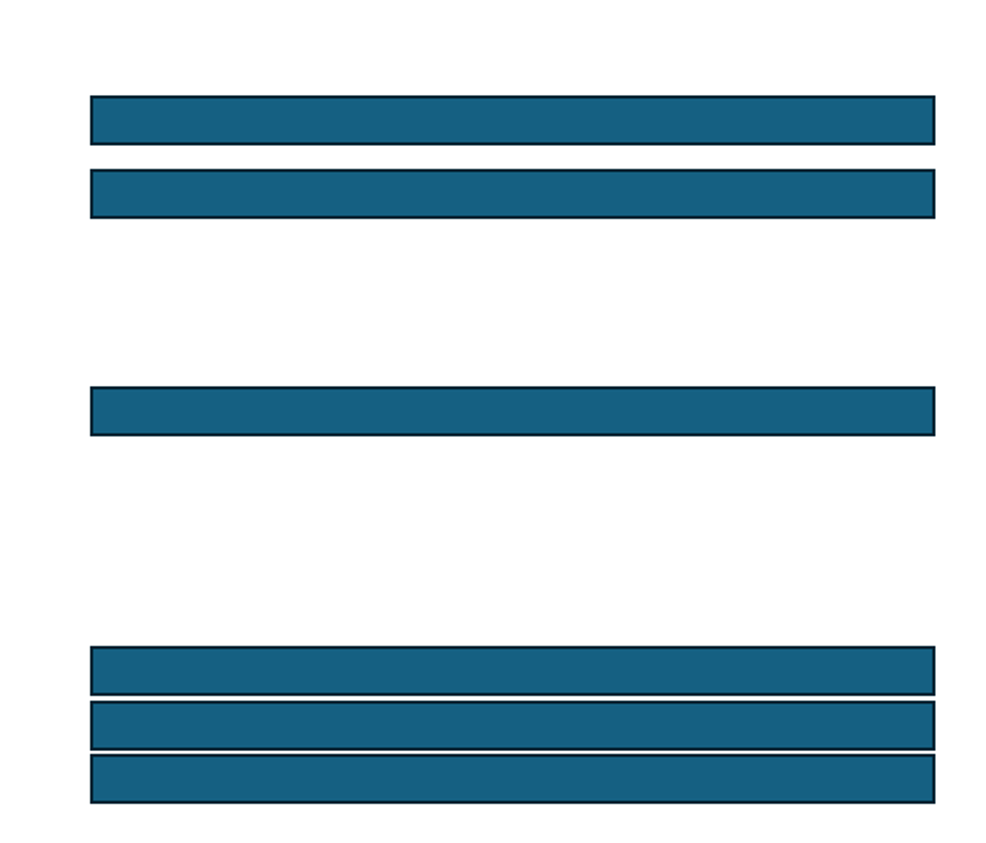

In [3]:
current_directory=  os.path.dirname(os.getcwd())

data = ANT.importDatafile(current_directory+"\\ProAnubisData\\60sRun_24_3_4.h5")
etaHits_old, phiHits_old = ANT.divideHitCountsByRPC(data)

The above cell imports the data from the h5 file for a run. The divideHitCountsByRPC function goes through each event and creates two arrays etaHits and phiHits. These two arrays contain information on how many hits a specific strip in the eta or phi direction recorded during an event.

Example data for an event, showing the number of hits detected by each of the 32 strips in the eta direction in each RPC.
(Should be eta not phi in the diagram)

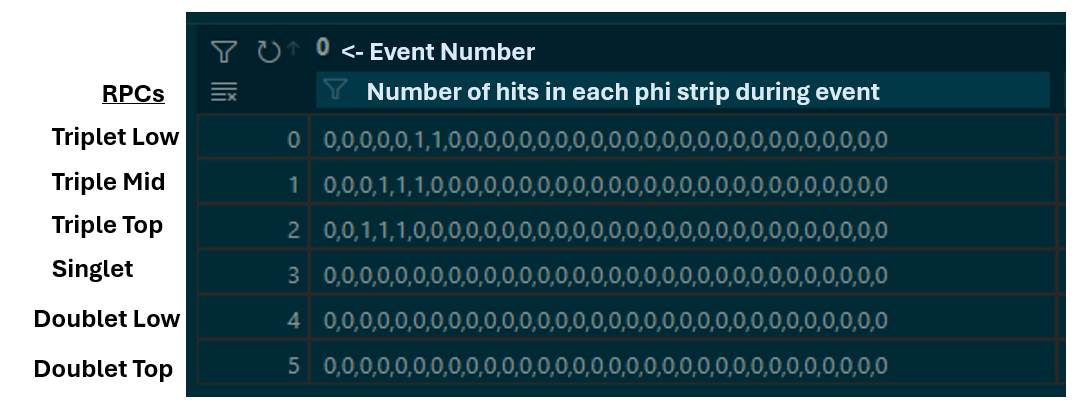

Visualisation of a possible trajectory. This possible event seemed to pass through all three RPCs in the triplet layer, and seems to have missed the other two layers (doublet and singlet).

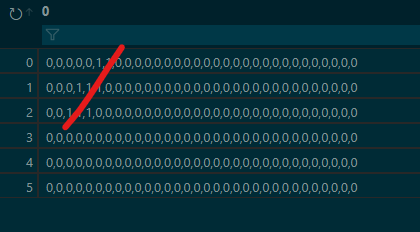

Now I would like to include the timing information for each hit. Note that sometimes a single strip has two or more hits in one event. We need to filter clusters based on timing window between hits.

Below is the function being modified to achieve this timing information.

Anything below 200 TDC time should be considered dark counts (?)

In [4]:
def countChannels_Timed(events):
    #Expects events from one TDC, counts how many hits each channel has within the event list
    chanCounts = [[] for x in range(128)]
    for event in events:
        for word in event:

            #get time of event
            time = word&0xfffff

            try:
                #Append time of event to specific channel triggered to get event.
                chanCounts[(word>>24)&0x7f].append(time)
            except:
                print(word>>24)
    return chanCounts

def divideHitCountsByRPC_Timed(data):
    #Divides the number of hits in each channel into individual RPCs
    etaHits = [[],[],[],[],[],[]]
    phiHits = [[],[],[],[],[],[]]
    for event in range(0,len(data[0])):
        tdcCounts = [countChannels_Timed([data[tdc][event]]) for tdc in range(5)]
        etaHits[0].append(tdcCounts[0][0:32]) #Triplet Eta Low
        phiHits[0].append(tdcCounts[0][32:96]) #Triplet Phi low
        etaHits[1].append(tdcCounts[0][96:128]) #Triplet Eta Mid
        phiHits[1].append(tdcCounts[1][0:64]) #Triplet Phi Mid
        etaHits[2].append(tdcCounts[1][64:96]) #Triplet Eta Top
        phiHits[2].append(tdcCounts[1][96:128]+tdcCounts[2][0:32]) #Triplet Phi Top
        etaHits[3].append(tdcCounts[2][32:64])#Singlet Eta
        phiHits[3].append(tdcCounts[2][64:128])#Singlet Phi
        etaHits[4].append(tdcCounts[3][0:32])#Double Eta low
        phiHits[4].append(tdcCounts[3][32:96])#Double Phi Low
        etaHits[5].append(tdcCounts[3][96:128])#Doublet Eta top
        phiHits[5].append(tdcCounts[4][0:64])#Doublet Phi top
    return etaHits,phiHits


etaHits, phiHits = divideHitCountsByRPC_Timed(data)

The above code now registers the time for each hit and stores this information in a list for each channel in each rpc for each event.

eg

[[], [], [], [], [], [266], [267], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [] …]

This is an example of two channels in the phi strips of an RPC being hit at times 266 and 267 in TDC time units. The difference in timing is likely due to the distance of the hit from the read out strips varying.

Now, to reconstruct events I would first like to identify hits that occured together in a specific time window. Specified by the time_window variable.

Below, a 1D scan of etaHits is used to determine when interesting events occur.

In [65]:
time_window = 25
trigger_num = 3

i = 0

#data_selected  = [row[0:2] for row in etaHits]

data_selected= etaHits

events = []

for event in range(0,len(data_selected[0])):
    #Scan over all events in the data collection
    i+=1
    print(i)

    for t in range(0,1250,time_window):
    #Scan over time bins in the event. This is sub-optimal, will likely miss events. But counting each step is expensive and risks double counting hits.
        
        hit_locations = []
        #hit_locations for hits within a time window. [RPC,strip]. Effectively z and x or y coordinate.
        
        for RPC in range(5):
        #Scan through hits of each RPC

            hits = data_selected[RPC][event] #Extracting relevant element of data_selected.

            for strip,hit_times in enumerate(hits):
                #Scan through each strip, check if a hit lies within the time_window of current bin. If it does, save the coordinates of the hit.
                if not hit_times:
                    continue

                for hit_time in hit_times:
                    if t<hit_time < t+time_window:
                        hit_locations.append([RPC,strip])
                        break

        if len(hit_locations)> 0:
            #Only save the data if an actual event occurs in the list. 
            events.append([f'Event {i}',t, hit_locations])
        else:
            continue

print(events)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


Now I have extracted coincident events in the 1D eta channel scan. 

['Event x', TIMEBIN, hit_locations]

However, within these coincident events there are separate "clusters" of events. A cluster is defined as a set of neighbouring strips firing off in the set time_window (all members of a cluster are connected through an activated strip).

Therefore, further analysis must be done to separate clusters in the events recorded above.

Furthermore, we currently only have data from the eta channel. We must now combine this with data from the phi channel. 

In [8]:
time_window = 25
#trigger_num = 3

i = 0

events = []

for event in range(0,len(etaHits[0])):
    #Scan over all events in the data collection
    i+=1
    print(i)

    for t in range(0,1250,time_window):
    #Scan over time bins in the event. This is sub-optimal, will likely miss events. But counting each step is expensive and risks double counting hits.
        
        hit_locations = []
        #hit_locations for hits within a time window. [RPC,strip]. Effectively z and x or y coordinate.
        
        for RPC in range(5):
        #Scan through hits of each RPC

            hits_eta = etaHits[RPC][event] #Extracting relevant element of etaHits
            hits_phi = phiHits[RPC][event] #Extracting relevant element of phiHits

            for strip,hit_times in enumerate(hits_eta):
                #Scan through each strip, check if a hit lies within the time_window of current bin. If it does, save the coordinates of the hit.
                if not hit_times:
                    continue

                for hit_time in hit_times:
                    if t<hit_time < t+time_window:
                        hit_locations.append([RPC,strip,'eta'])
                        break

            for strip,hit_times in enumerate(hits_phi):
                #Scan through each strip, check if a hit lies within the time_window of current bin. If it does, save the coordinates of the hit.
                if not hit_times:
                    continue

                for hit_time in hit_times:
                    if t<hit_time < t+time_window:
                        hit_locations.append([RPC,strip,'phi'])
                        break

        if len(hit_locations)> 0:
            #Only save the data if an actual event occurs in the list. 
            events.append([f'Event {i}',t, hit_locations])
        else:
            continue

print(events)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


Now I have the "x,y,RPC" coords of each hit in a group of "coincident" hits. Using this data, we can study cluster distributions. This includes dark counts & real muons. We can filter out dark counts by considering only timebins < ~200 TDC time (after 250 TDC time the trigger event arrives). 

WOULD THIS BE BIASING THE SAMPLE OF CLUSTER DISTRIBUTIONS ?

In [100]:
#Based on the above description, I will now filter out events that are due to darkcounts.

dark_count_events = [x for x in events if x[1] < 225-time_window]
print(dark_count_events)
print(f'Number of dark count events: {len(dark_count_events)}')

[['Event 4', 100, [[4, 31, 'eta']]], ['Event 11', 25, [[4, 31, 'eta']]], ['Event 12', 150, [[0, 0, 'phi'], [3, 0, 'phi']]], ['Event 29', 150, [[4, 31, 'eta']]], ['Event 35', 0, [[2, 2, 'phi']]], ['Event 35', 25, [[2, 28, 'eta']]], ['Event 44', 75, [[0, 0, 'phi'], [2, 0, 'phi']]], ['Event 63', 0, [[4, 21, 'phi']]], ['Event 63', 25, [[4, 13, 'eta']]], ['Event 68', 50, [[4, 31, 'eta']]], ['Event 68', 100, [[4, 31, 'eta']]], ['Event 72', 175, [[1, 0, 'phi'], [4, 13, 'eta'], [4, 37, 'phi']]], ['Event 77', 0, [[4, 0, 'phi']]], ['Event 77', 50, [[0, 0, 'phi'], [2, 0, 'phi']]], ['Event 78', 75, [[0, 0, 'phi']]], ['Event 87', 175, [[2, 39, 'phi']]], ['Event 98', 175, [[0, 0, 'phi']]], ['Event 114', 25, [[0, 0, 'phi'], [2, 0, 'phi']]], ['Event 114', 75, [[4, 0, 'phi']]], ['Event 115', 175, [[0, 0, 'phi'], [3, 0, 'phi']]], ['Event 121', 0, [[0, 0, 'phi']]], ['Event 121', 25, [[0, 0, 'phi'], [2, 0, 'phi']]], ['Event 121', 125, [[0, 0, 'phi'], [2, 0, 'phi'], [3, 0, 'phi']]], ['Event 121', 150, [[3,

Viewing the data, it would appear that the 31 Eta Doublet channel is responsible for alot of noise. Indeed looking at the heatmap for the 60s run we find this is a particularly noisy channel:

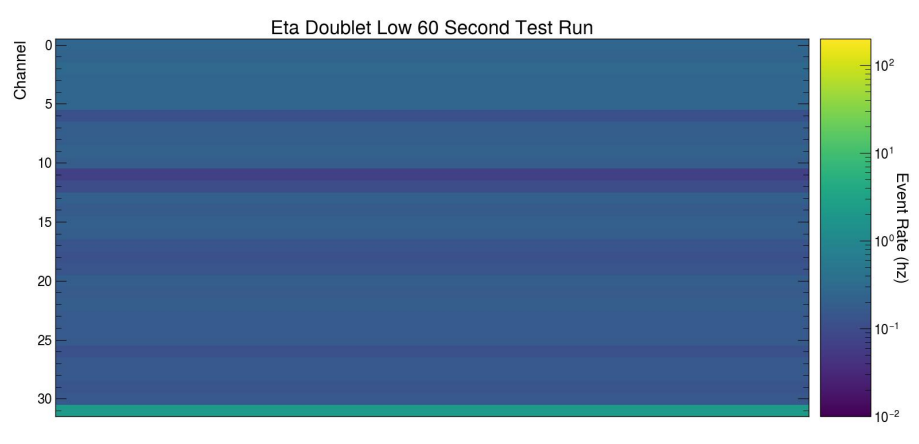

Ok, so we now have a list of likely candidate dark count events. Dark counts will not be correlated between different RPCs, therefore we should work out cluster distributions for each RPC seperately. 

The tricky part is extracting separate clusters from the same RPC. Hits in the same cluster must be connected in some way.

The code below is attempting to find the cluster distribution for each RPC.

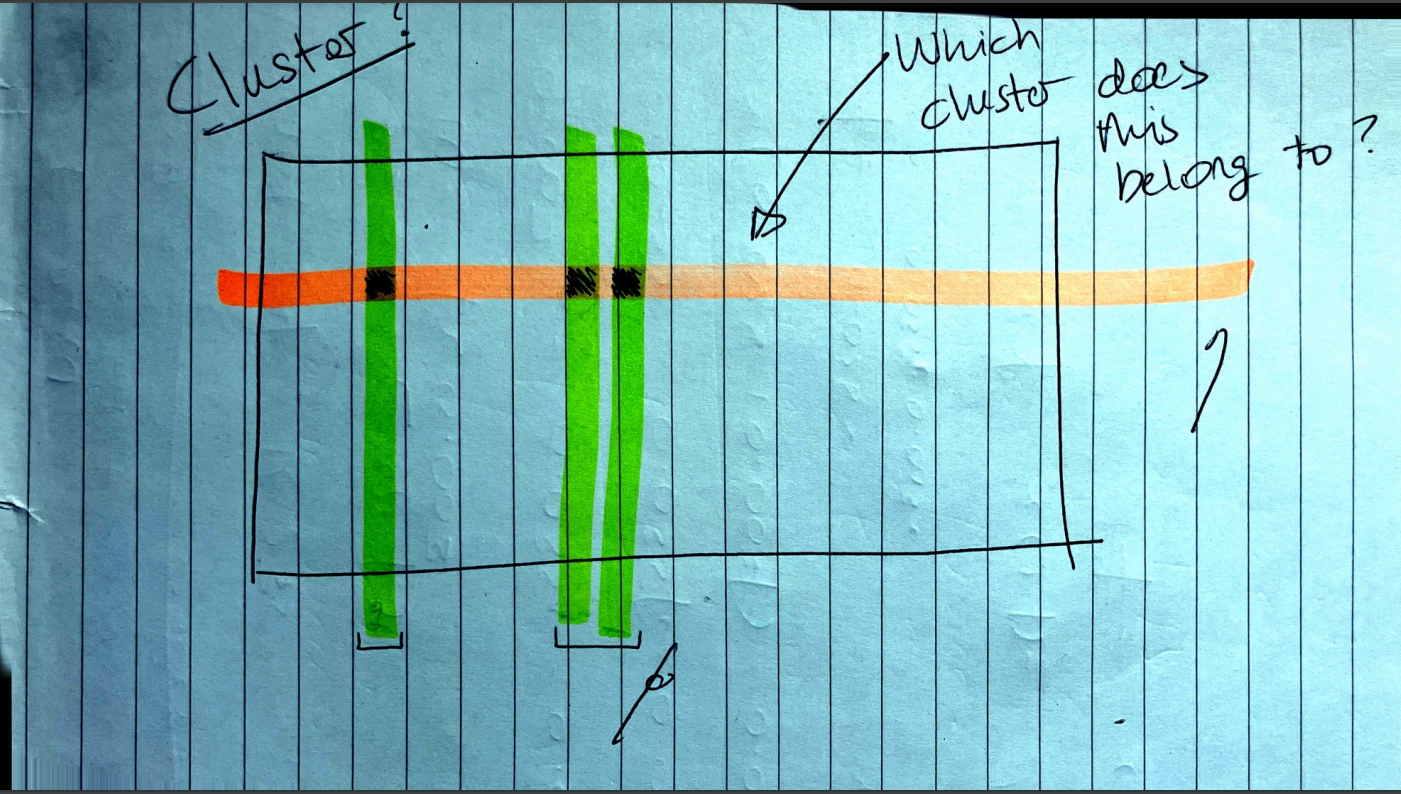

In [101]:
phi_cluster_distribution = [[] for _ in range(6)] # [[RPC1],[RPC2],[RPC3],...]
eta_cluster_distribution = [[] for _ in range(6)]

for event in dark_count_events:
    print(event)

    # event : ['Event x', TIMEBIN, [hit_locations]]
    hit_locations = event[2]
    #hit_locations = [[RPC,CHANNEL,eta/phi]...]

    #Extract hit_locations in phi and eta directions.
    phi_locations = [x for x in hit_locations if x[2]=='phi']
    eta_locations = [x for x in hit_locations if x[2]=='eta']

    #Sort by channels
    phi_locations = sorted(phi_locations, key=lambda x: x[1])
    eta_locations = sorted(eta_locations, key=lambda x: x[1])

    for RPC in range(6):
        #Work out the cluster distribution for each RPC this specific dark count event.

        rpc_phi_locations = [x[1] for x in phi_locations if x[0]==RPC]#could join with previous statement for phi_locations
        rpc_eta_locations = [x[1] for x in eta_locations if x[0]==RPC]

        rpc_phi_clusters = []
        rpc_eta_clusters = []

        i = 0
        for ind,location in enumerate(rpc_phi_locations):
            
            if ind ==0:
                previous_element = location
                rpc_phi_clusters.append([location])
            else:
                if abs(location - previous_element) != 1:
                    # Hit is not part of the same cluster
                    rpc_phi_clusters.append([location])
                    i += 1
                else:
                    # Hit is part of the same cluster
                    rpc_phi_clusters[i].append(location)

                previous_element = location

        j = 0
        for ind,location in enumerate(rpc_eta_locations):
        
            if ind ==0:
                previous_element = location
                rpc_eta_clusters.append([location])

            else:

                if abs(location - previous_element) != 1:
                    # Hit is not part of the same cluster
                    rpc_eta_clusters.append([location])
                    j += 1
                else:
                    # Hit is part of the same cluster
                    rpc_eta_clusters[j].append(location)

                previous_element = location

        print(rpc_phi_clusters,rpc_eta_clusters,f"RPC={RPC}")


['Event 4', 100, [[4, 31, 'eta']]]
[] [] RPC=0
[] [] RPC=1
[] [] RPC=2
[] [] RPC=3
[] [[31]] RPC=4
[] [] RPC=5
['Event 11', 25, [[4, 31, 'eta']]]
[] [] RPC=0
[] [] RPC=1
[] [] RPC=2
[] [] RPC=3
[] [[31]] RPC=4
[] [] RPC=5
['Event 12', 150, [[0, 0, 'phi'], [3, 0, 'phi']]]
[[0]] [] RPC=0
[] [] RPC=1
[] [] RPC=2
[[0]] [] RPC=3
[] [] RPC=4
[] [] RPC=5
['Event 29', 150, [[4, 31, 'eta']]]
[] [] RPC=0
[] [] RPC=1
[] [] RPC=2
[] [] RPC=3
[] [[31]] RPC=4
[] [] RPC=5
['Event 35', 0, [[2, 2, 'phi']]]
[] [] RPC=0
[] [] RPC=1
[[2]] [] RPC=2
[] [] RPC=3
[] [] RPC=4
[] [] RPC=5
['Event 35', 25, [[2, 28, 'eta']]]
[] [] RPC=0
[] [] RPC=1
[] [[28]] RPC=2
[] [] RPC=3
[] [] RPC=4
[] [] RPC=5
['Event 44', 75, [[0, 0, 'phi'], [2, 0, 'phi']]]
[[0]] [] RPC=0
[] [] RPC=1
[[0]] [] RPC=2
[] [] RPC=3
[] [] RPC=4
[] [] RPC=5
['Event 63', 0, [[4, 21, 'phi']]]
[] [] RPC=0
[] [] RPC=1
[] [] RPC=2
[] [] RPC=3
[[21]] [] RPC=4
[] [] RPC=5
['Event 63', 25, [[4, 13, 'eta']]]
[] [] RPC=0
[] [] RPC=1
[] [] RPC=2
[] [] RPC=3

Based on the above cell, I am now confident that I have clustered the dark counts correctly. All that is left to do is count their sizes and plot their distributions for each RPC.

In [105]:
phi_cluster_distribution = [[] for _ in range(6)] # [[RPC1],[RPC2],[RPC3],...]
eta_cluster_distribution = [[] for _ in range(6)]

# k = 0

for event in dark_count_events:
    # k+=1
    # print(k)

    # event : ['Event x', TIMEBIN, [hit_locations]]
    hit_locations = event[2]
    #hit_locations = [[RPC,CHANNEL,eta/phi]...]

    #Extract hit_locations in phi and eta directions.
    phi_locations = [x for x in hit_locations if x[2]=='phi']
    eta_locations = [x for x in hit_locations if x[2]=='eta']

    #Sort by channels
    phi_locations = sorted(phi_locations, key=lambda x: x[1])
    eta_locations = sorted(eta_locations, key=lambda x: x[1])

    for RPC in range(6):
        #Work out the cluster distribution for each RPC this specific dark count event.

        rpc_phi_locations = [x[1] for x in phi_locations if x[0]==RPC]#could join with previous statement for phi_locations
        rpc_eta_locations = [x[1] for x in eta_locations if x[0]==RPC]

        rpc_phi_clusters = []
        rpc_eta_clusters = []

        i = 0
        for ind,location in enumerate(rpc_phi_locations):
            
            if ind ==0:
                previous_element = location
                rpc_phi_clusters.append([location])
            else:
                if abs(location - previous_element) != 1:
                    # Hit is not part of the same cluster
                    rpc_phi_clusters.append([location])
                    i += 1
                else:
                    # Hit is part of the same cluster
                    rpc_phi_clusters[i].append(location)

                previous_element = location

        j = 0
        for ind,location in enumerate(rpc_eta_locations):
        
            if ind ==0:
                previous_element = location
                rpc_eta_clusters.append([location])

            else:

                if abs(location - previous_element) != 1:
                    # Hit is not part of the same cluster
                    rpc_eta_clusters.append([location])
                    j += 1
                else:
                    # Hit is part of the same cluster
                    rpc_eta_clusters[j].append(location)

                previous_element = location

        for x in rpc_phi_clusters:
            phi_cluster_distribution[RPC].append(len(x))
        for y in rpc_eta_clusters:
            eta_cluster_distribution[RPC].append(len(y))


print(eta_cluster_distribution)
print(phi_cluster_distribution)

[[1, 1], [], [1, 1, 3, 1, 1, 1], [], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1], []]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], []]


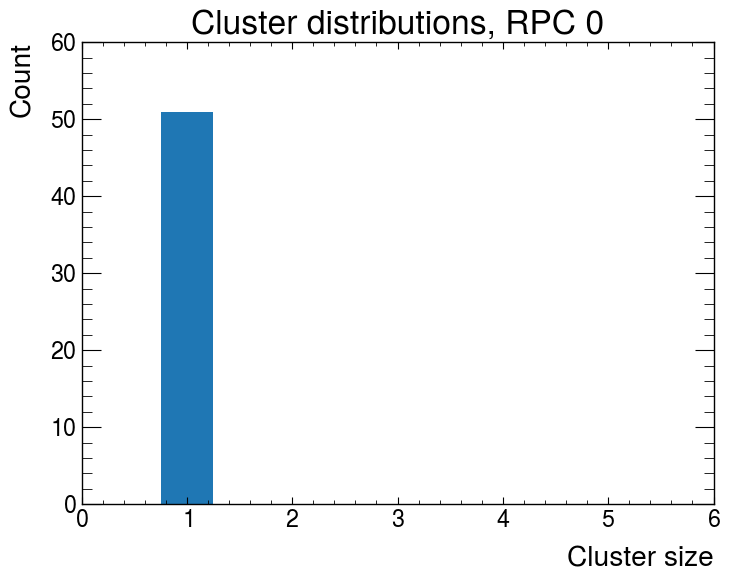

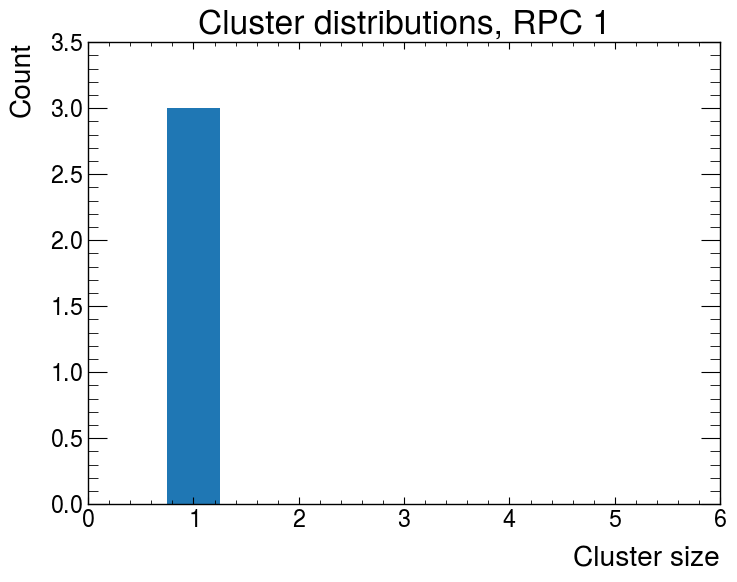

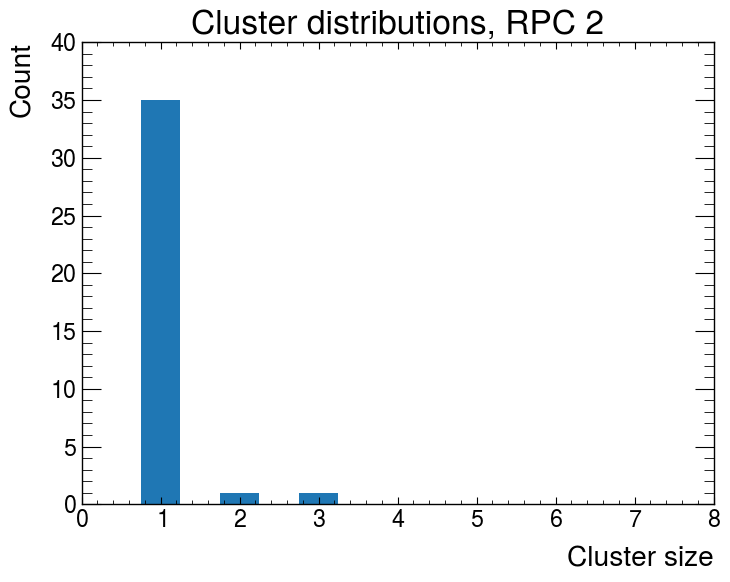

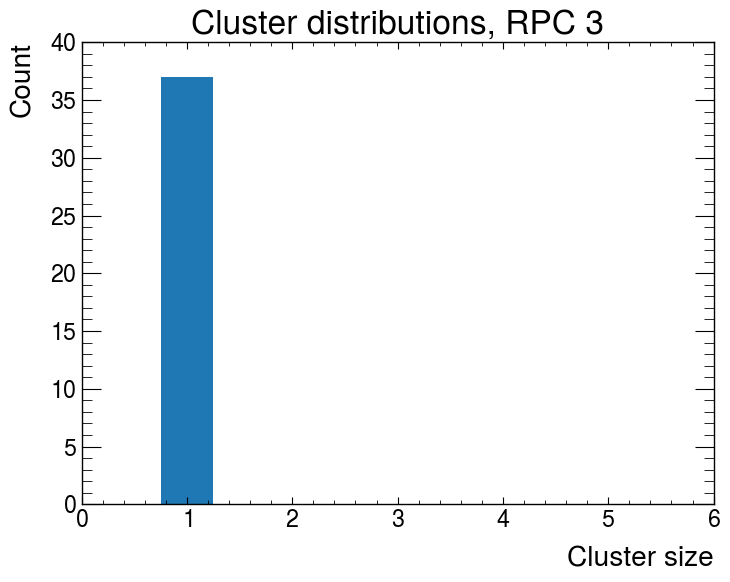

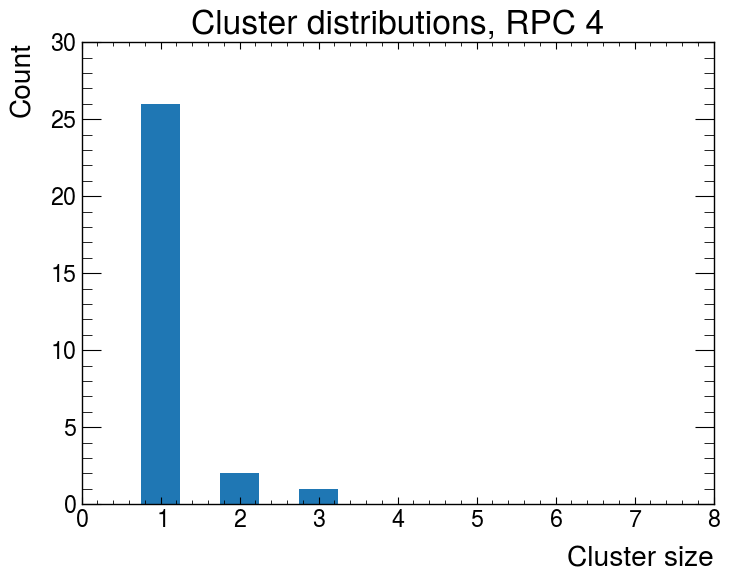

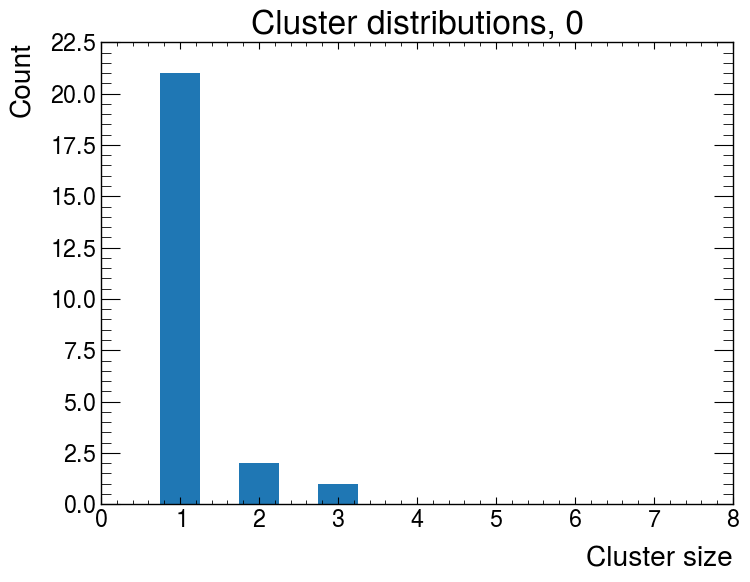

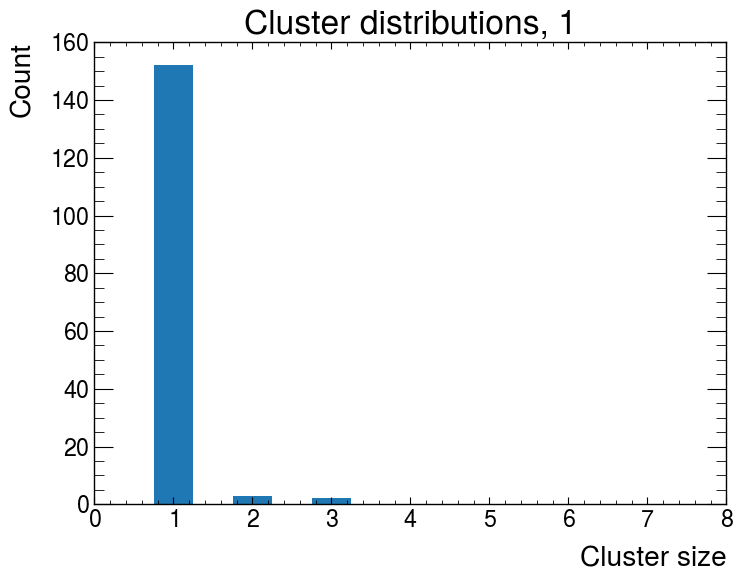

In [131]:
for RPC in range(6):

    if phi_cluster_distribution[RPC]:
        plt.figure()
        #plt.hist(eta_cluster_distribution[RPC])

        # Calculate bin edges centered on integers
        bin_edges = [i - 0.5 for i in range(min(phi_cluster_distribution[RPC]), max(phi_cluster_distribution[RPC]) + 2)]

        plt.hist(phi_cluster_distribution[RPC], bins=bin_edges, align='mid', rwidth=0.5)
        plt.xlabel('Cluster size')
        plt.ylabel('Count')
        plt.xlim(0,max(phi_cluster_distribution[RPC])+5)
        plt.title(f'Cluster distributions, RPC {RPC}')
        #plt.grid(True)
        plt.show()

phi_combined = []
[phi_combined.extend(lst) for lst in phi_cluster_distribution]

eta_combined = []
[eta_combined.extend(lst) for lst in eta_cluster_distribution]

combined_data = [eta_combined,phi_combined]

for i,x in enumerate(combined_data):

    plt.figure()
    #plt.hist(eta_cluster_distribution[RPC])

    # Calculate bin edges centered on integers
    bin_edges = [i - 0.5 for i in range(min(x), max(x) + 2)]

    plt.hist(x, bins=bin_edges, align='mid', rwidth=0.5)
    plt.xlabel('Cluster size')
    plt.ylabel('Count')
    plt.xlim(0,max(x)+5)
    plt.title(f'Cluster distributions, {i}')
    #plt.grid(True)
    plt.show()




The above plot is only for dark count data below 225 TDC over 60 seconds. We can improve the sample massively by using the 3 hour data set instead.

Takes about 7 minutes to load in the data set.

In [139]:
current_directory=  os.path.dirname(os.getcwd())

data_3 = ANT.importDatafile(current_directory+"\\ProAnubisData\\threeHourRun_24_3_1.h5")
etaHits_3, phiHits_3 = divideHitCountsByRPC_Timed(data_3)

In [141]:
time_window = 25
#trigger_num = 3

i = 0

events_3 = []

for event in range(0,len(etaHits_3[0])):
    #Scan over all events in the data collection
    i+=1
    print(i)

    for t in range(0,1250,time_window):
    #Scan over time bins in the event. This is sub-optimal, will likely miss events. But counting each step is expensive and risks double counting hits.
        
        hit_locations = []
        #hit_locations for hits within a time window. [RPC,strip]. Effectively z and x or y coordinate.
        
        for RPC in range(5):
        #Scan through hits of each RPC

            hits_eta = etaHits_3[RPC][event] #Extracting relevant element of etaHits
            hits_phi = phiHits_3[RPC][event] #Extracting relevant element of phiHits

            for strip,hit_times in enumerate(hits_eta):
                #Scan through each strip, check if a hit lies within the time_window of current bin. If it does, save the coordinates of the hit.
                if not hit_times:
                    continue

                for hit_time in hit_times:
                    if t<hit_time < t+time_window:
                        hit_locations.append([RPC,strip,'eta'])
                        break

            for strip,hit_times in enumerate(hits_phi):
                #Scan through each strip, check if a hit lies within the time_window of current bin. If it does, save the coordinates of the hit.
                if not hit_times:
                    continue

                for hit_time in hit_times:
                    if t<hit_time < t+time_window:
                        hit_locations.append([RPC,strip,'phi'])
                        break

        if len(hit_locations)> 0:
            #Only save the data if an actual event occurs in the list. 
            events.append([f'Event {i}',t, hit_locations])
        else:
            continue

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [142]:
#Based on the above description, I will now filter out events that are due to darkcounts.

dark_count_events = [x for x in events if x[1] < 225-time_window]
print(dark_count_events)
print(f'Number of dark count events: {len(dark_count_events)}')

[['Event 4', 100, [[4, 31, 'eta']]], ['Event 11', 25, [[4, 31, 'eta']]], ['Event 12', 150, [[0, 0, 'phi'], [3, 0, 'phi']]], ['Event 29', 150, [[4, 31, 'eta']]], ['Event 35', 0, [[2, 2, 'phi']]], ['Event 35', 25, [[2, 28, 'eta']]], ['Event 44', 75, [[0, 0, 'phi'], [2, 0, 'phi']]], ['Event 63', 0, [[4, 21, 'phi']]], ['Event 63', 25, [[4, 13, 'eta']]], ['Event 68', 50, [[4, 31, 'eta']]], ['Event 68', 100, [[4, 31, 'eta']]], ['Event 72', 175, [[1, 0, 'phi'], [4, 13, 'eta'], [4, 37, 'phi']]], ['Event 77', 0, [[4, 0, 'phi']]], ['Event 77', 50, [[0, 0, 'phi'], [2, 0, 'phi']]], ['Event 78', 75, [[0, 0, 'phi']]], ['Event 87', 175, [[2, 39, 'phi']]], ['Event 98', 175, [[0, 0, 'phi']]], ['Event 114', 25, [[0, 0, 'phi'], [2, 0, 'phi']]], ['Event 114', 75, [[4, 0, 'phi']]], ['Event 115', 175, [[0, 0, 'phi'], [3, 0, 'phi']]], ['Event 121', 0, [[0, 0, 'phi']]], ['Event 121', 25, [[0, 0, 'phi'], [2, 0, 'phi']]], ['Event 121', 125, [[0, 0, 'phi'], [2, 0, 'phi'], [3, 0, 'phi']]], ['Event 121', 150, [[3,

In [143]:
phi_cluster_distribution = [[] for _ in range(6)] # [[RPC1],[RPC2],[RPC3],...]
eta_cluster_distribution = [[] for _ in range(6)]

# k = 0

for event in dark_count_events:
    # k+=1
    # print(k)

    # event : ['Event x', TIMEBIN, [hit_locations]]
    hit_locations = event[2]
    #hit_locations = [[RPC,CHANNEL,eta/phi]...]

    #Extract hit_locations in phi and eta directions.
    phi_locations = [x for x in hit_locations if x[2]=='phi']
    eta_locations = [x for x in hit_locations if x[2]=='eta']

    #Sort by channels
    phi_locations = sorted(phi_locations, key=lambda x: x[1])
    eta_locations = sorted(eta_locations, key=lambda x: x[1])

    for RPC in range(6):
        #Work out the cluster distribution for each RPC this specific dark count event.

        rpc_phi_locations = [x[1] for x in phi_locations if x[0]==RPC]#could join with previous statement for phi_locations
        rpc_eta_locations = [x[1] for x in eta_locations if x[0]==RPC]

        rpc_phi_clusters = []
        rpc_eta_clusters = []

        i = 0
        for ind,location in enumerate(rpc_phi_locations):
            
            if ind ==0:
                previous_element = location
                rpc_phi_clusters.append([location])
            else:
                if abs(location - previous_element) != 1:
                    # Hit is not part of the same cluster
                    rpc_phi_clusters.append([location])
                    i += 1
                else:
                    # Hit is part of the same cluster
                    rpc_phi_clusters[i].append(location)

                previous_element = location

        j = 0
        for ind,location in enumerate(rpc_eta_locations):
        
            if ind ==0:
                previous_element = location
                rpc_eta_clusters.append([location])

            else:

                if abs(location - previous_element) != 1:
                    # Hit is not part of the same cluster
                    rpc_eta_clusters.append([location])
                    j += 1
                else:
                    # Hit is part of the same cluster
                    rpc_eta_clusters[j].append(location)

                previous_element = location

        for x in rpc_phi_clusters:
            phi_cluster_distribution[RPC].append(len(x))
        for y in rpc_eta_clusters:
            eta_cluster_distribution[RPC].append(len(y))

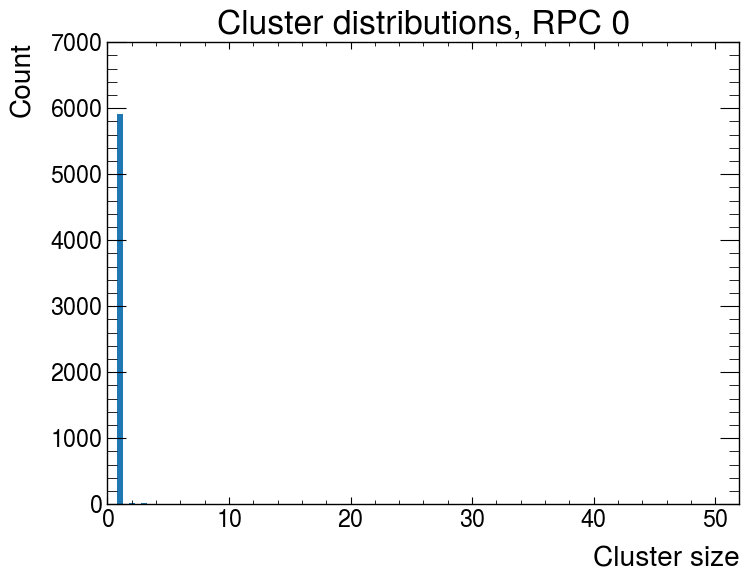

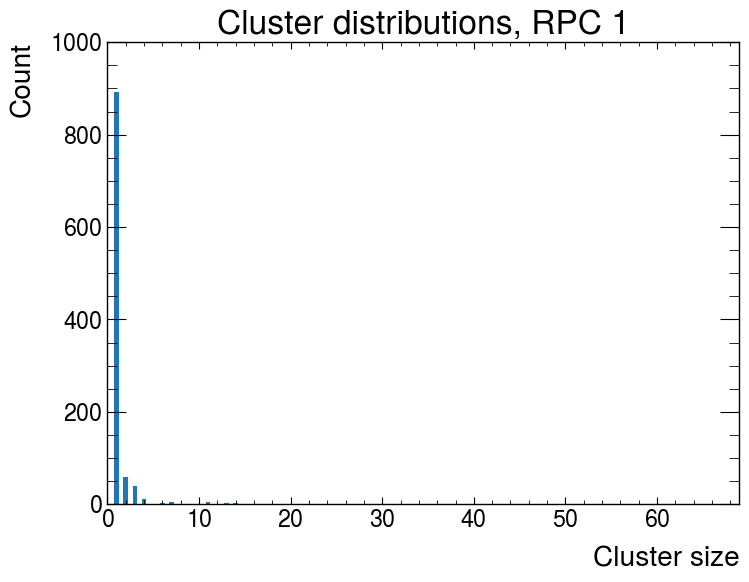

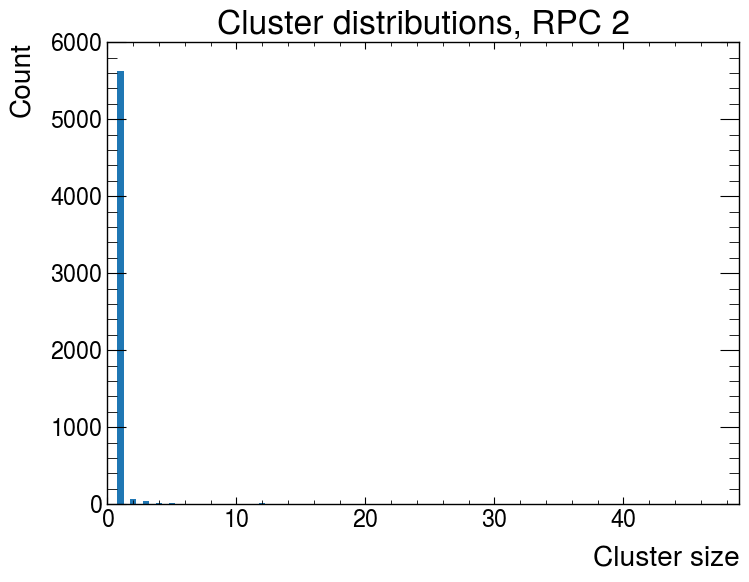

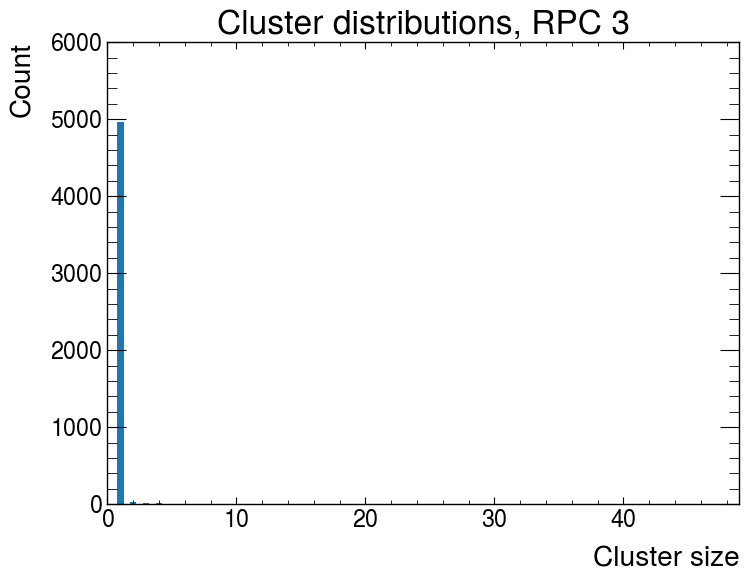

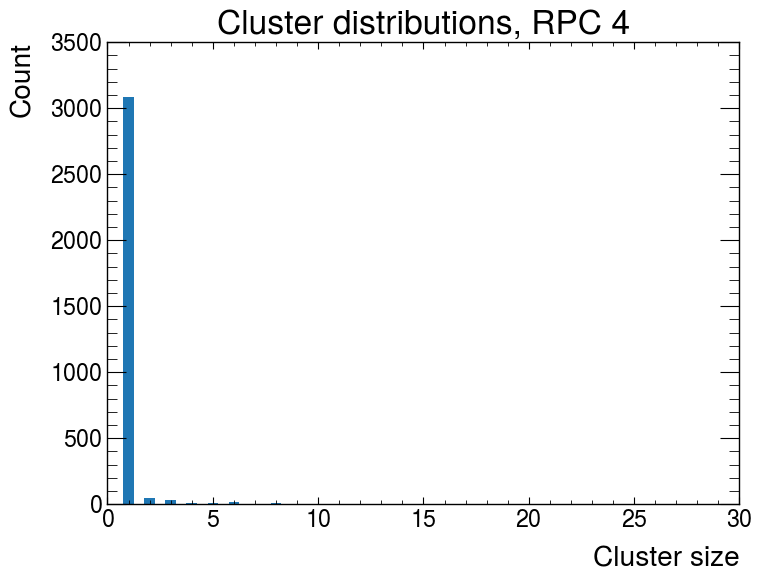

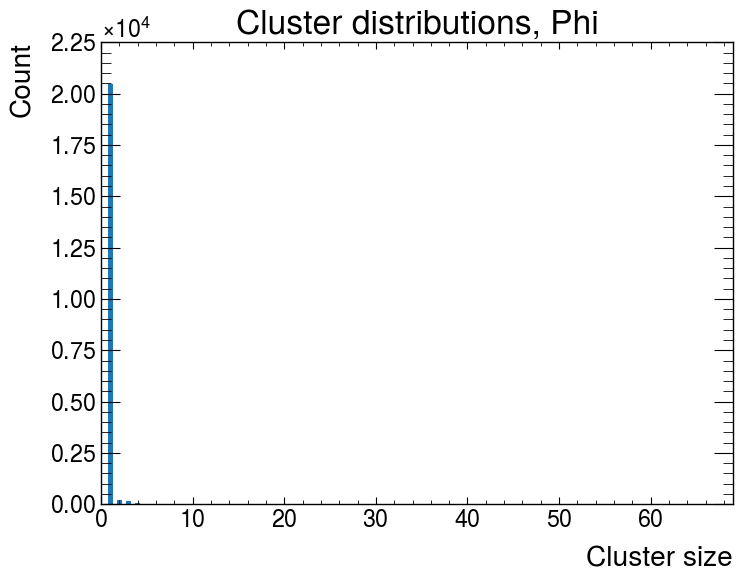

In [148]:
for RPC in range(6):

    if phi_cluster_distribution[RPC]:
        plt.figure()
        #plt.hist(eta_cluster_distribution[RPC])

        # Calculate bin edges centered on integers
        bin_edges = [i - 0.5 for i in range(min(phi_cluster_distribution[RPC]), max(phi_cluster_distribution[RPC]) + 2)]

        plt.hist(phi_cluster_distribution[RPC], bins=bin_edges, align='mid', rwidth=0.5)
        plt.xlabel('Cluster size')
        plt.ylabel('Count')
        plt.xlim(0,max(phi_cluster_distribution[RPC])+5)
        plt.title(f'Cluster distributions, RPC {RPC}')
        #plt.grid(True)
        plt.show()

phi_combined = []
[phi_combined.extend(lst) for lst in phi_cluster_distribution]

eta_combined = []
[eta_combined.extend(lst) for lst in eta_cluster_distribution]


plt.figure()
#plt.hist(eta_cluster_distribution[RPC])
# Calculate bin edges centered on integers
bin_edges = [i - 0.5 for i in range(min(phi_combined), max(phi_combined) + 2)]
plt.hist(phi_combined, bins=bin_edges, align='mid', rwidth=0.5)
plt.xlabel('Cluster size')
plt.ylabel('Count')
plt.xlim(0,max(phi_combined)+5)
plt.title(f'Cluster distributions, Phi')
#plt.grid(True)
plt.show()

# plt.figure()
# #plt.hist(eta_cluster_distribution[RPC])
# # Calculate bin edges centered on integers
# bin_edges = [i - 0.5 for i in range(min(eta_combined), max(eta_combined) + 2)]
# plt.hist(x, bins=bin_edges, align='mid', rwidth=0.5)
# plt.xlabel('Cluster size')
# plt.ylabel('Count')
# plt.xlim(0,max(x)+5)
# plt.title(f'Cluster distributions, Eta')
# #plt.grid(True)
# plt.show()



A couple things to note. Noisy channels may be dominating these measurements. May be worth ignoring these. 

Secondly, there are events with VERY large number of coincident hits. Are these the noise bursts?

To fix this, put max limit on cluster size saved (eg 10)

In [150]:
anomalous_events = [x for x in dark_count_events if len(x[2])>50]
print(anomalous_events)

[['Event 8720', 75, [[0, 62, 'phi'], [0, 63, 'phi'], [1, 62, 'phi'], [2, 1, 'eta'], [2, 3, 'eta'], [2, 5, 'eta'], [2, 6, 'eta'], [2, 8, 'eta'], [2, 9, 'eta'], [2, 10, 'eta'], [2, 12, 'eta'], [2, 13, 'eta'], [2, 14, 'eta'], [2, 16, 'eta'], [2, 17, 'eta'], [2, 18, 'eta'], [2, 20, 'eta'], [2, 21, 'eta'], [2, 22, 'eta'], [2, 23, 'eta'], [2, 24, 'eta'], [2, 25, 'eta'], [2, 26, 'eta'], [2, 27, 'eta'], [2, 28, 'eta'], [2, 29, 'eta'], [2, 30, 'eta'], [2, 0, 'phi'], [2, 1, 'phi'], [2, 2, 'phi'], [2, 4, 'phi'], [2, 5, 'phi'], [2, 6, 'phi'], [2, 7, 'phi'], [2, 8, 'phi'], [2, 9, 'phi'], [2, 10, 'phi'], [2, 11, 'phi'], [2, 12, 'phi'], [2, 13, 'phi'], [2, 14, 'phi'], [2, 15, 'phi'], [2, 16, 'phi'], [2, 17, 'phi'], [2, 18, 'phi'], [2, 21, 'phi'], [2, 23, 'phi'], [2, 24, 'phi'], [2, 25, 'phi'], [2, 26, 'phi'], [2, 44, 'phi'], [2, 45, 'phi'], [2, 46, 'phi'], [2, 48, 'phi'], [2, 49, 'phi'], [2, 50, 'phi'], [2, 51, 'phi'], [2, 52, 'phi'], [2, 53, 'phi'], [2, 54, 'phi'], [2, 55, 'phi'], [2, 56, 'phi'], [2